In [6]:
import pandas as pd
import numpy as np

In [7]:
testPath='../release/test.jsonl'
trainPath='../release/train.jsonl'


In [8]:
df = pd.read_json(trainPath, lines=True)
df.head()

,url,archive,title,date,text,summary,compression,coverage,density,compression_bin,coverage_bin,density_bin
0,http://www.nytimes.com/2006/06/04/sports/socce...,http://web.archive.org/web/20060618204254id_/h...,Surge in Racist Mood Raises Concerns on Eve of...,1970-08-21 04:23:38.204254,"HAMBURG, Germany, June 3  As he left the socc...",A surge in discriminatory behavior toward blac...,137.470588,1.000000,7.823529,high,high,mixed
1,http://www.nytimes.com/2005/12/24/politics/24s...,http://web.archive.org/web/20060620043011id_/h...,"Spy Agency Mined Vast Data Trove, Officials Re...",1970-08-21 04:23:40.043011,"WASHINGTON, Dec. 23 - The National Security Ag...","The volume of information harvested, without \...",33.636364,0.909091,4.727273,medium,medium,mixed
2,http://www.nytimes.com/2006/04/23/business/you...,http://web.archive.org/web/20060909062911id_/h...,Investors vs. Pfizer: Guess Who Has the Guns?,1970-08-21 04:28:29.062911,IF outsized executive pay has indeed become a ...,The battle between Pfizer Inc.'s investors and...,33.880000,1.000000,11.720000,medium,high,extractive
3,http://www.nydailynews.com/archives/gossip/199...,http://web.archive.org/web/20080313232743id_/h...,REX FLEXED PECS FOR SKIN PICS,1970-08-21 09:51:53.232743,BY A.J. BENZA & MICHAEL LEWITTES\n\nIf Simon R...,"If Simon Rex looks a little familiar, it may n...",11.894118,0.988235,38.988235,low,high,extractive
4,http://www.nydailynews.com/archives/entertainm...,http://web.archive.org/web/20080314003027id_/h...,POPEYE-WORTHY PIE. PHYLLO DOUGH WRAPS SPINACH ...,1970-08-21 09:51:54.003027,Spinach has terrorized generations of veggie-p...,POPEYE-WORTHY PIE. PHYLLO DOUGH WRAPS SPINACH ...,3.932584,0.921348,36.629213,low,medium,extractive


In [9]:
categories = {
    'architecture': ['architect', 'building', 'construction', 'structure'],
        'food': ['recipe', 'cuisine', 'cook', 'restaurant', 'food', 'dish','chef','healthy'],
        'entertainment': ['movie', 'show','music', 'celebrity', 'actor', 'tv', 'film', 'hollywood', 'cinema', 'theatre'],
        'sports': ['sport', 'athlete', 'league', 'tournament','game', 'football', 'cricket','hockey'],
        'technology': ['tech', 'software', 'hardware', 'programming', 'gadget', 'app','phone','laptop','apple','microsoft','meta']
}

In [10]:
import re
from urllib.parse import urlparse

def extract_keywords_from_url(url):
    parsed_url = urlparse(url)
    path = parsed_url.path
    keywords = re.findall(r'/([a-zA-Z0-9-]+)', path)
    return [keyword.lower() for keyword in keywords if keyword]

def categorize_url(url):
    url = url.lower()
    for category, keywords in categories.items():
        pattern = re.compile('|'.join(f'.*{re.escape(keyword)}.*' for keyword in keywords))
        if any(pattern.match(keyword) for keyword in extract_keywords_from_url(url)):
            return category
    return 'other'

df['category'] = df['url'].apply(categorize_url)

In [11]:
category_counts = df['category'].value_counts()
print(category_counts)

category
other            807420
entertainment     60980
sports            59724
technology        49978
food              13454
architecture       3485
Name: count, dtype: int64


In [12]:
df_new=df[-(df['category']=='other')].copy()

### Analyzing the POS for each category

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import string
import pandas as pd
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
from wordcloud import WordCloud
# nltk.download('averaged_perceptron_tagger_eng')

In [13]:

stop_words = set(stopwords.words('english'))
def preprocess_text(text):
    text = str(text)
    text = text.replace('\n', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = [word.lower() for word in text.split() if word.lower() not in stop_words]
    return tokens

In [25]:
df_new['cleaned_text'] = df_new['text'].apply(preprocess_text)

In [14]:
df_new['cleaned_summary'] = df_new['summary'].apply(preprocess_text)

In [28]:
def analyze_pos_by_category(df):
    pos_dist_by_category = {}
    top_nouns_by_category = {}

    for category, group in df.groupby('category'):
        all_pos_tags = []
        all_nouns = []

        for cleaned_text in group['cleaned_text']:
            pos_tags = pos_tag(cleaned_text)

            for word, tag in pos_tags:
                all_pos_tags.append(tag)
                if tag.startswith('NN'):
                    all_nouns.append(word)

        total_pos_tags = len(all_pos_tags)

        pos_counter = Counter(all_pos_tags)

        normalized_pos_counter = {tag: count / total_pos_tags for tag, count in pos_counter.items()}
        pos_dist_by_category[category] = dict(normalized_pos_counter)

        noun_counter = Counter(all_nouns)
        top_nouns_by_category[category] = noun_counter.most_common(5)

    return pos_dist_by_category, top_nouns_by_category


In [29]:
# Analyze POS tag distribution and prominent nouns by category
pos_distribution, prominent_nouns = analyze_pos_by_category(df_new)

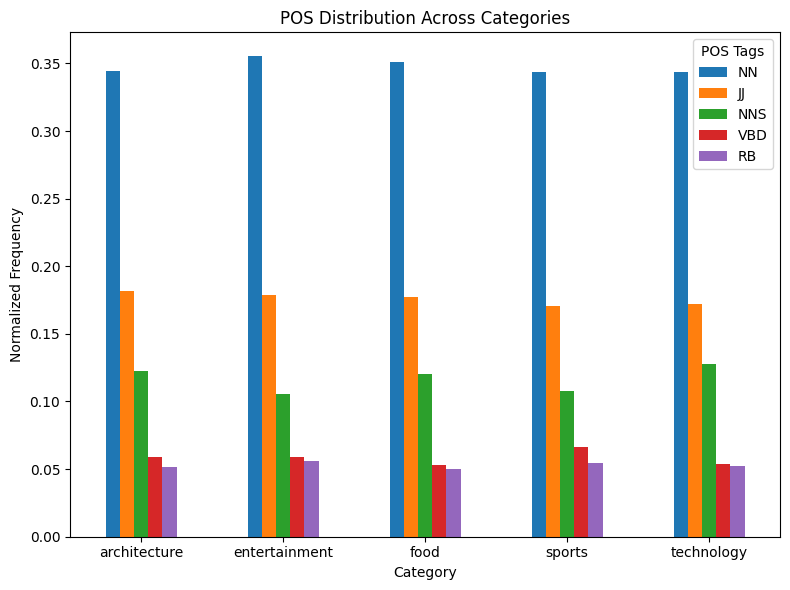

In [33]:


def plot_pos_distribution(pos_distribution):
    pos_df = pd.DataFrame(pos_distribution).T
    pos_df = pos_df.fillna(0)
    top_pos_tags = pos_df.sum().nlargest(5).index
    pos_df_top = pos_df[top_pos_tags]

    # Plot
    pos_df_top.plot(kind='bar', figsize=(8, 6))
    plt.title('POS Distribution Across Categories')
    plt.xlabel('Category')
    plt.ylabel('Normalized Frequency')
    plt.legend(title='POS Tags')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

plot_pos_distribution(pos_distribution)

In [34]:
prominent_nouns

{'architecture': [('building', 5753),
  ('people', 4663),
  ('buildings', 4064),
  ('city', 4027),
  ('years', 3636)],
 'entertainment': [('film', 65215),
  ('people', 63871),
  ('time', 59220),
  ('—', 53577),
  ('music', 49238)],
 'food': [('food', 32372),
  ('people', 14333),
  ('time', 11077),
  ('image', 10440),
  ('restaurant', 9893)],
 'sports': [('game', 136961),
  ('season', 85295),
  ('team', 84165),
  ('time', 73235),
  ('games', 71768)],
 'technology': [('apple', 67962),
  ('people', 60225),
  ('company', 49357),
  ('time', 42608),
  ('year', 37563)]}

### Analyse Frequencies and Text Length of Categories

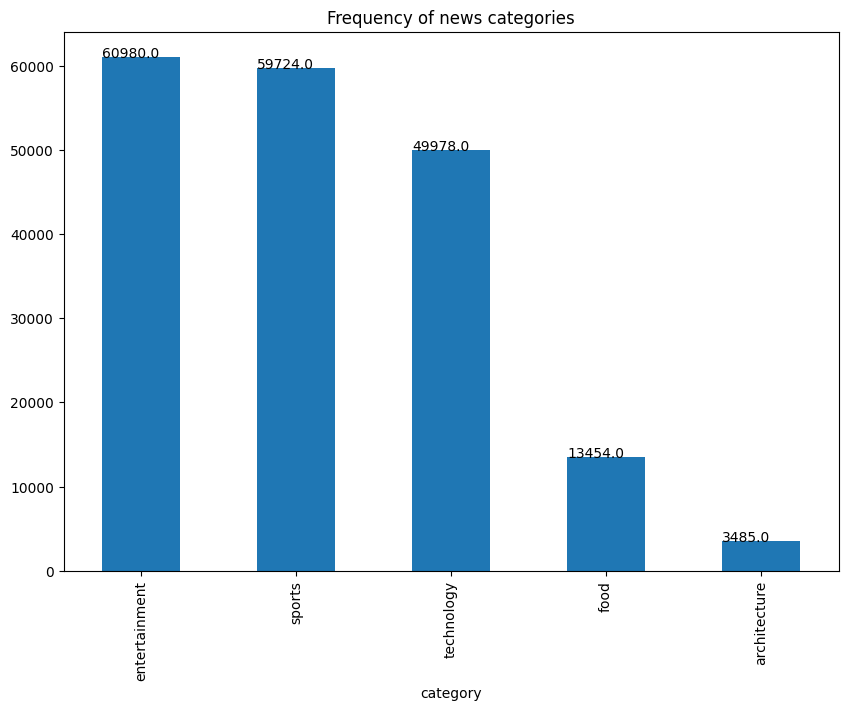

In [37]:
ax = df_new['category'].value_counts().plot(kind='bar', figsize=(10,7))
for p in ax.patches:
    ax.annotate("{:.1f}".format(p.get_height()), (p.get_x(), p.get_height()+5))
plt.title("Frequency of news categories")
plt.show()

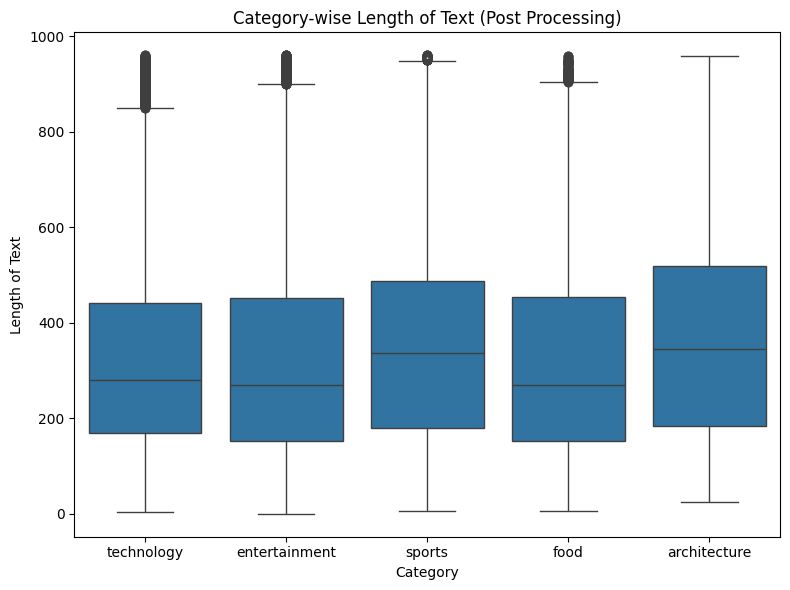

In [46]:
df_new['text_length'] = df_new['cleaned_text'].apply(len)

def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    # Define lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Filter the DataFrame to remove outliers
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df_cleaned = remove_outliers_iqr(df_new, 'text_length')
means = df_cleaned.groupby('category')['text_length'].mean()


plt.figure(figsize=(8, 6))
sns.boxplot(x='category', y='text_length', data=df_cleaned)
plt.title('Category-wise Length of Text (Post Processing)')
plt.xlabel('Category')
plt.ylabel('Length of Text')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [47]:
print("Mean Length of Text by Category:")
print(means)

Mean Length of Text by Category:
category
architecture     366.153614
entertainment    316.162979
food             319.633824
sports           350.364853
technology       319.374007
Name: text_length, dtype: float64


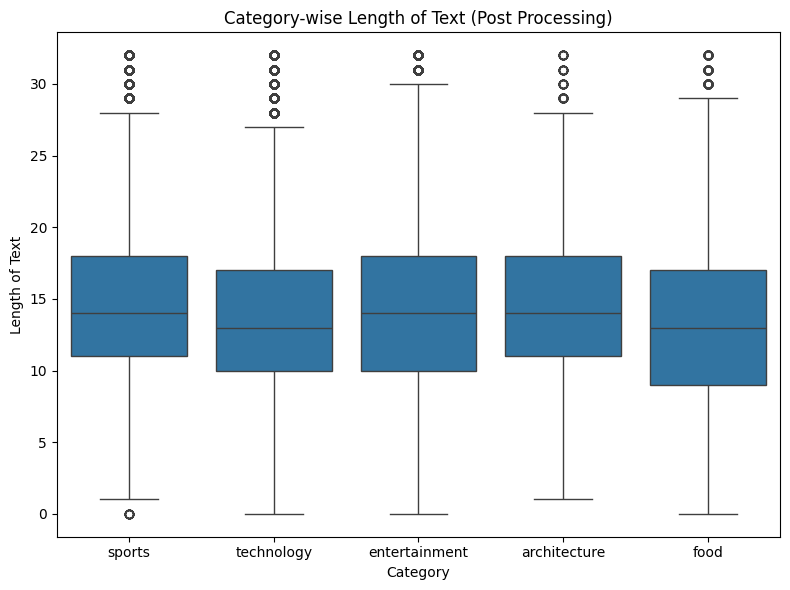

In [17]:
df_new['summary_length'] = df_new['cleaned_summary'].apply(len)

def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    # Define lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Filter the DataFrame to remove outliers
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df_cleaned = remove_outliers_iqr(df_new, 'summary_length')
means = df_cleaned.groupby('category')['summary_length'].mean()


plt.figure(figsize=(8, 6))
sns.boxplot(x='category', y='summary_length', data=df_cleaned)
plt.title('Category-wise Length of Text (Post Processing)')
plt.xlabel('Category')
plt.ylabel('Length of Text')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [18]:
print("Mean Length of Summary by Category:")
print(means)

Mean Length of Summary by Category:
category
architecture     14.471054
entertainment    14.254656
food             13.359642
sports           14.913351
technology       13.853362
Name: summary_length, dtype: float64


In [ ]:
# Combine all news articles into one string for visualization
all_news = ' '.join(df['news_'])

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_news)

# Display the word cloud
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

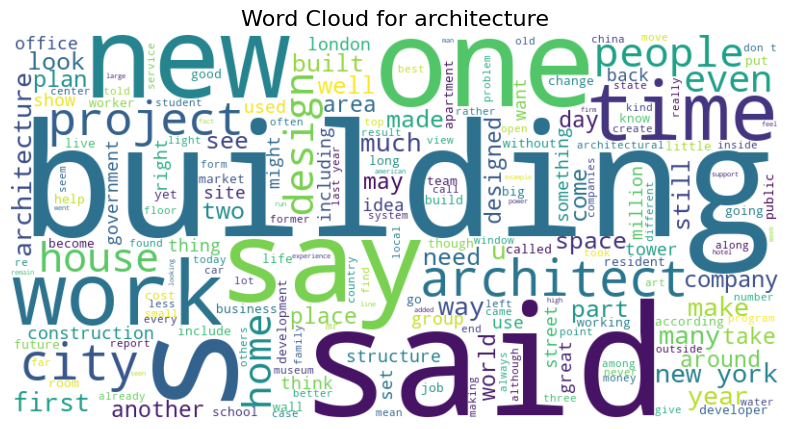

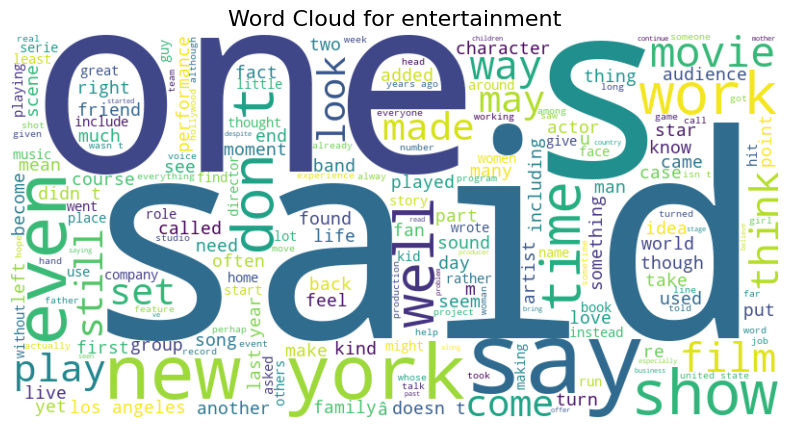

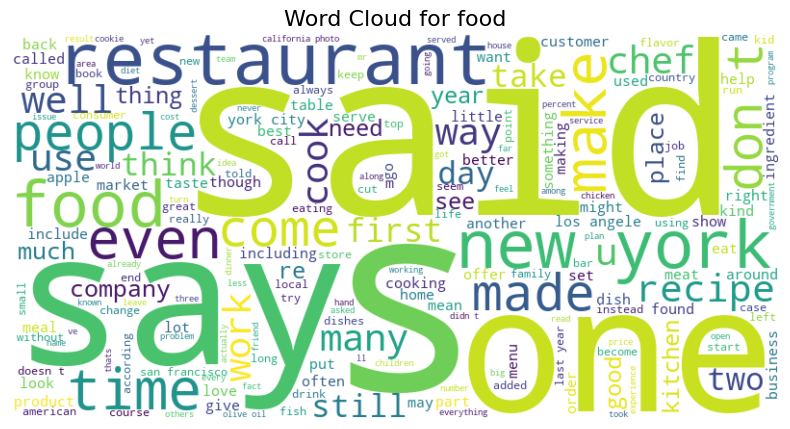

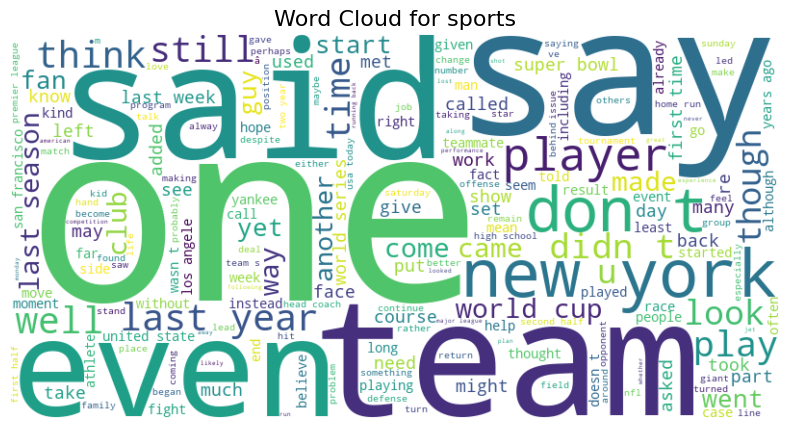

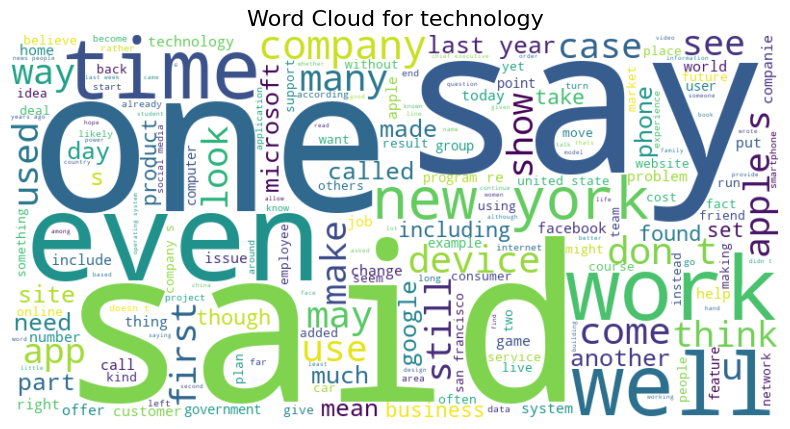

In [50]:
def generate_wordcloud(text, label):
    data = ' '.join([' '.join(words) for words in text])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(data)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {label}', fontsize=16)
    plt.show()

# Group data by 'labels' and generate word clouds for each category
label_groups = df_new.groupby('category')

for label, group in label_groups:
    generate_wordcloud(df_new[df_new['category'] == label]['cleaned_text'], label)

### Getting the test data

In [5]:
df_test = pd.read_json(testPath, lines=True)
df_test['category'] = df_test['url'].apply(categorize_url)
category_counts = df_test['category'].value_counts()
print(category_counts)

category
other            88682
entertainment     6668
sports            6163
technology        5448
food              1482
architecture       419
Name: count, dtype: int64
